# Nombre: Jesús Alberto Aréchiga Carrillo

In [93]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

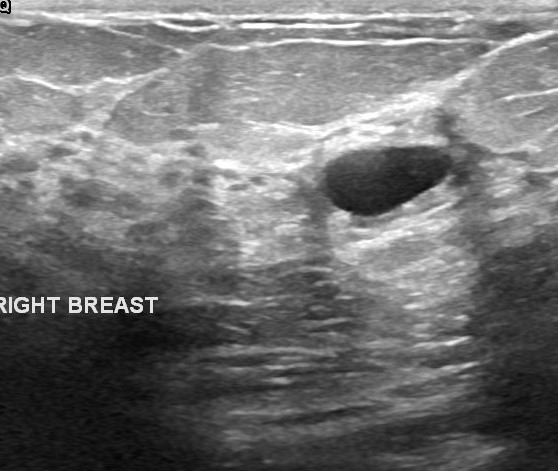

In [94]:
img = cv2.imread("benign.png")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray)

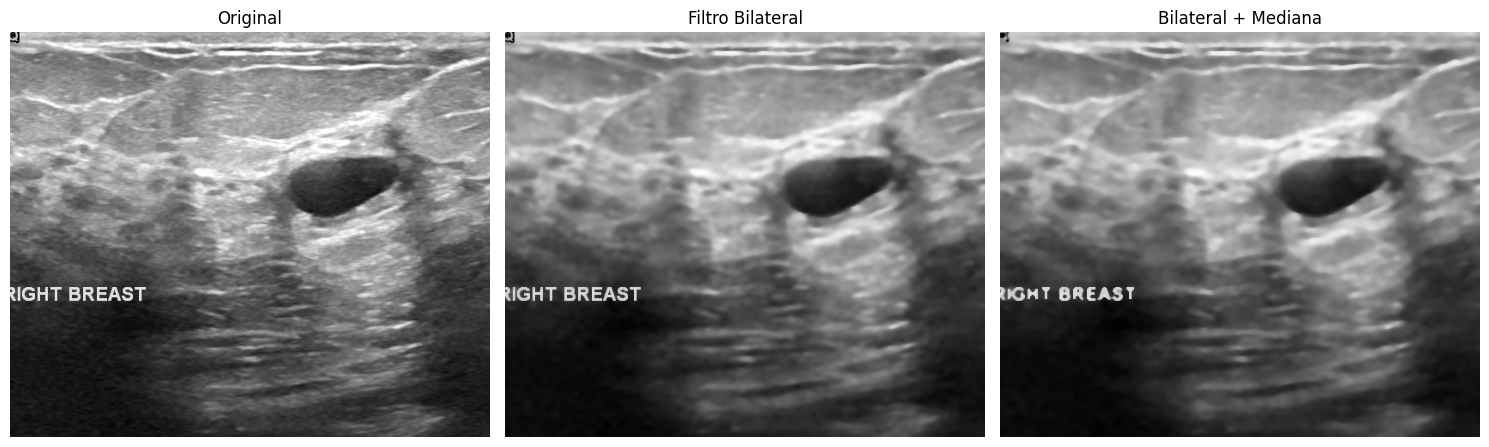

In [95]:
bilateral = cv2.bilateralFilter(gray, d=9, sigmaColor=75, sigmaSpace=75)
median = cv2.medianBlur(bilateral, 5)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')
axes[1].imshow(bilateral, cmap='gray')
axes[1].set_title('Filtro Bilateral')
axes[1].axis('off')
axes[2].imshow(median, cmap='gray')
axes[2].set_title('Bilateral + Mediana')
axes[2].axis('off')
plt.tight_layout()
plt.show()

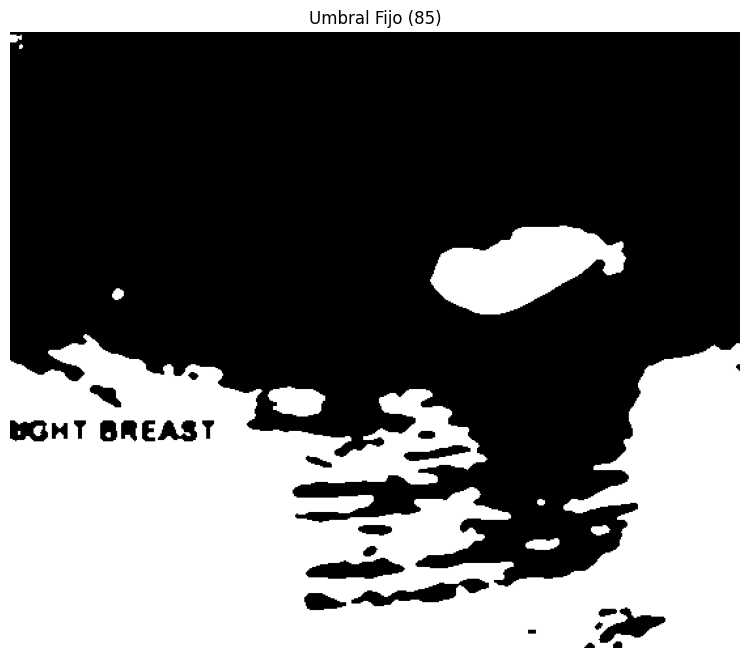

In [96]:
threshold_value = 85
_, fixed_thresh = cv2.threshold(median, threshold_value, 255, cv2.THRESH_BINARY_INV)

plt.imshow(fixed_thresh, cmap='gray')
plt.title(f'Umbral Fijo ({threshold_value})')
plt.axis('off')
plt.show()

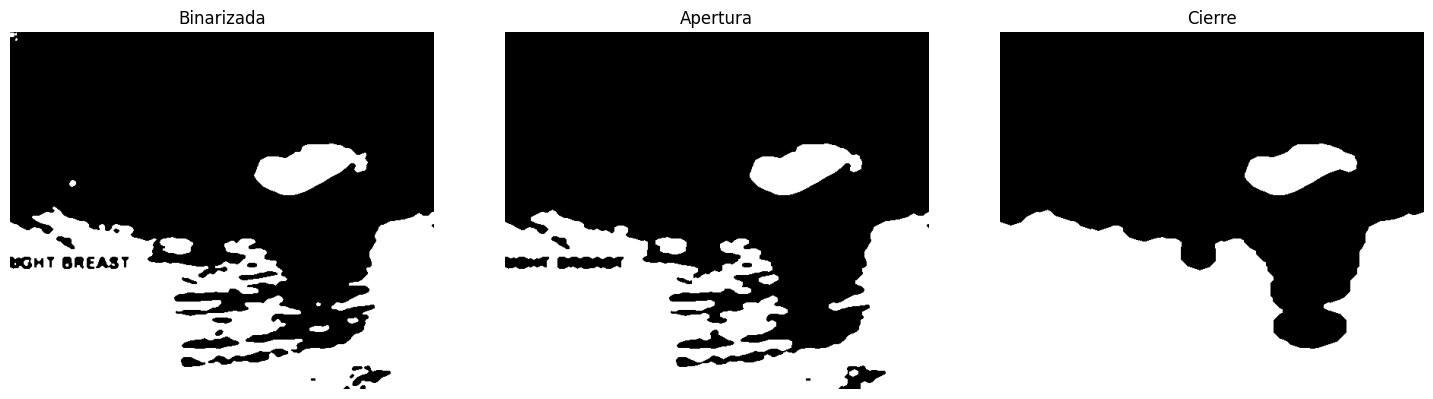

In [97]:
binary = fixed_thresh.copy()

kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel_medium = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
kernel_large = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))

# Apertura para eliminar ruido
opening = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel_medium, iterations=2)

# Cierre fuerte
closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_large, iterations=4)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(binary, cmap='gray')
axes[0].set_title('Binarizada')
axes[0].axis('off')
axes[1].imshow(opening, cmap='gray')
axes[1].set_title('Apertura')
axes[1].axis('off')
axes[2].imshow(closing, cmap='gray')
axes[2].set_title('Cierre')
axes[2].axis('off')
plt.tight_layout()
plt.show()

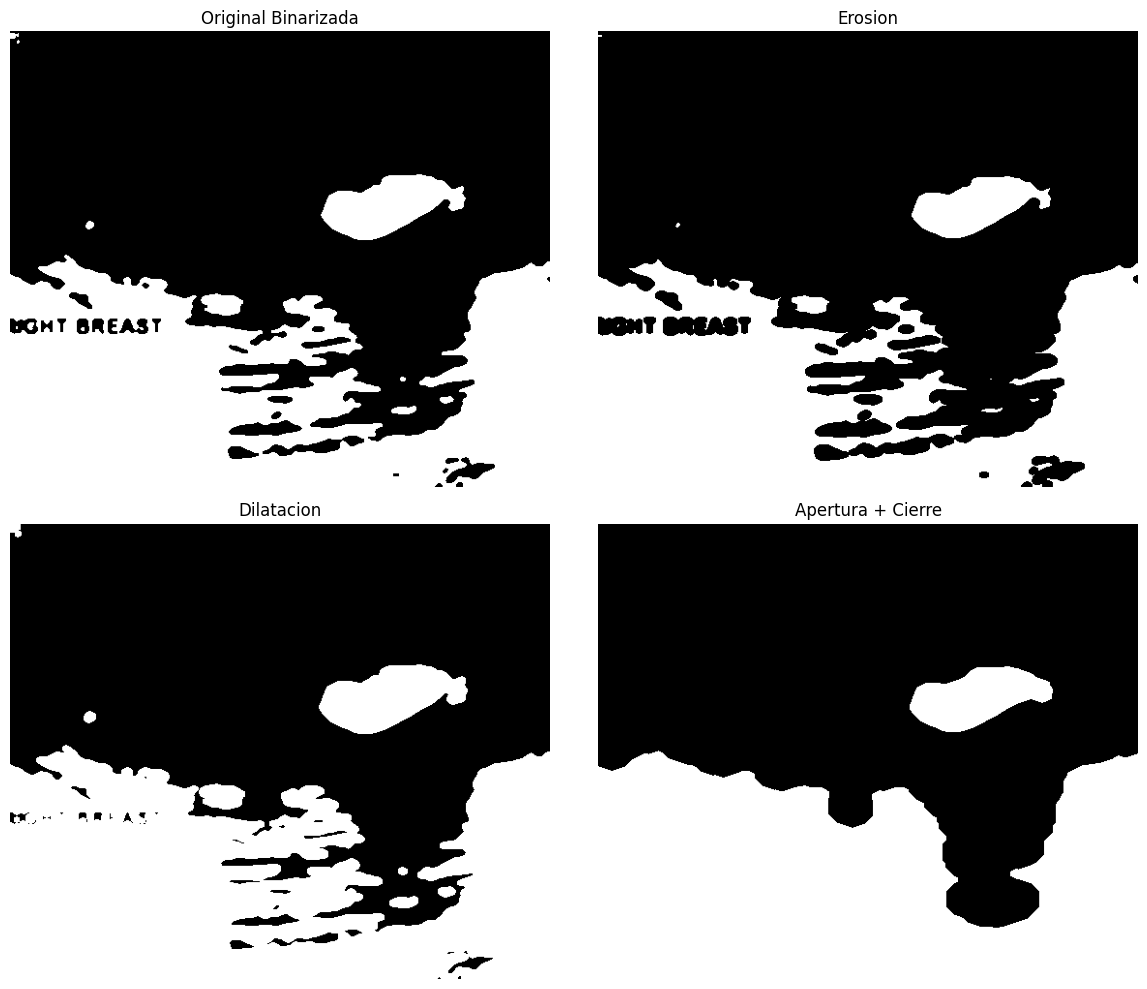

In [98]:
erosion = cv2.erode(binary, kernel_medium, iterations=1)
dilation = cv2.dilate(binary, kernel_medium, iterations=1)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes[0, 0].imshow(binary, cmap='gray')
axes[0, 0].set_title('Original Binarizada')
axes[0, 0].axis('off')
axes[0, 1].imshow(erosion, cmap='gray')
axes[0, 1].set_title('Erosion')
axes[0, 1].axis('off')
axes[1, 0].imshow(dilation, cmap='gray')
axes[1, 0].set_title('Dilatacion')
axes[1, 0].axis('off')
axes[1, 1].imshow(closing, cmap='gray')
axes[1, 1].set_title('Apertura + Cierre')
axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

In [99]:
contours, _ = cv2.findContours(closing, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Contornos encontrados: {len(contours)}')

min_area = 500
max_area = gray.shape[0] * gray.shape[1] * 0.3

valid_contours = []
for i, contour in enumerate(contours):
    area = cv2.contourArea(contour)
    if min_area < area < max_area:
        M = cv2.moments(contour)
        if M['m00'] != 0:
            cx = int(M['m10'] / M['m00'])
            cy = int(M['m01'] / M['m00'])
            valid_contours.append((contour, area, cx, cy))
            print(f'Contorno {i}: Area={area:.0f}, Centro=({cx}, {cy})')

valid_contours.sort(key=lambda x: x[1], reverse=True)

Contornos encontrados: 2
Contorno 1: Area=6074, Centro=(390, 179)


Tumor seleccionado: Area=6074, Centro=(390, 179)


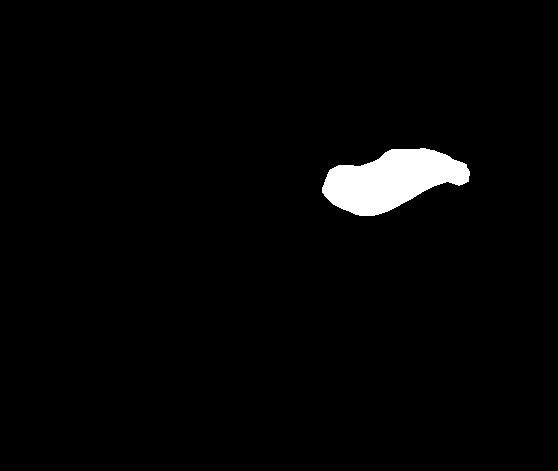

In [100]:
mask = np.zeros_like(gray)

if valid_contours:
    h, w = gray.shape
    tumor_contour = None

    for contour, area, cx, cy in valid_contours:
        if cy < h * 0.5 and cx > w * 0.4:
            tumor_contour = contour
            print(f'Tumor seleccionado: Area={area:.0f}, Centro=({cx}, {cy})')
            break

    if tumor_contour is None and valid_contours:
        tumor_contour = valid_contours[0][0]
        print('Usando el contorno mas grande')

    if tumor_contour is not None:
        cv2.drawContours(mask, [tumor_contour], -1, 255, -1)

cv2_imshow(mask)

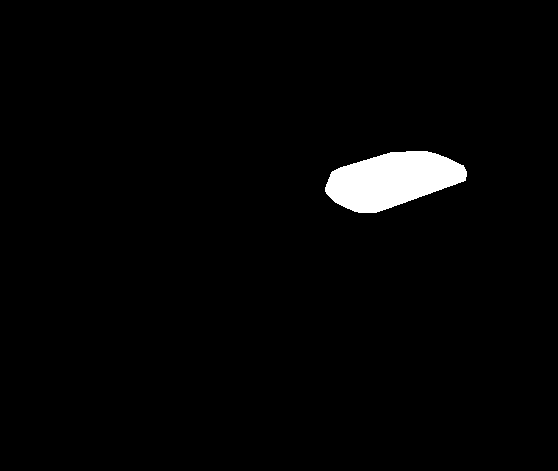

In [102]:
kernel_refine = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
refined_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_refine, iterations=2)

# Convex Hull para suavizar forma
contours_ref, _ = cv2.findContours(refined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if contours_ref:
    hull = cv2.convexHull(contours_ref[0])
    refined_mask = np.zeros_like(gray)
    cv2.drawContours(refined_mask, [hull], -1, 255, -1)

# Erosión para reducir el exceso
kernel_erode = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
refined_mask = cv2.erode(refined_mask, kernel_erode, iterations=1)

cv2_imshow(refined_mask)